# Lab: Customer Churn Prediction (EDA, Modelling & Research)
This lab focuses on **exploring the dataset, cleaning it, creating features, fitting a simple model, and reflecting** on how to evaluate models.

⚠️ **Note**: This dataset is synthetic and provided for academic purposes.

## Section 0 – Setup
Fill in your details and import the libraries you will need.

In [2]:
# add required imports here
# importing necessary packages
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\kelkess\AppData\Local\anaconda3\envs\cash\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# import df
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Section 1 – Data Exploration (25%)

In [4]:
## understand how the data looks
# view first 20 rows
print(df.head(20))
# data description
print("Data Types:")
print(df.dtypes)
print("\nMissing Values per Column:")
print(df.isnull().sum())


    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0   7590-VHVEG  Female              0     Yes         No       1           No   
1   5575-GNVDE    Male              0      No         No      34          Yes   
2   3668-QPYBK    Male              0      No         No       2          Yes   
3   7795-CFOCW    Male              0      No         No      45           No   
4   9237-HQITU  Female              0      No         No       2          Yes   
5   9305-CDSKC  Female              0      No         No       8          Yes   
6   1452-KIOVK    Male              0      No        Yes      22          Yes   
7   6713-OKOMC  Female              0      No         No      10           No   
8   7892-POOKP  Female              0     Yes         No      28          Yes   
9   6388-TABGU    Male              0      No        Yes      62          Yes   
10  9763-GRSKD    Male              0     Yes        Yes      13          Yes   
11  7469-LKBCI    Male      

### Q1: How many **unique customers** are in the dataset?

In [5]:
#hint: use pd.nunique function
unique_customers = df['customerID'].nunique()
print("Number of unique customers:", unique_customers)


Number of unique customers: 7043


In [6]:
#overview of data
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7395.000000,7395.000000,7395.000000
mean,0.161325,32.450575,64.748675
std,0.367856,24.551830,30.095367
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.450000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Since there is 7395 data points, and there are only 7043 unique data, then there are duplicates that shall be dealt with

In [7]:
duplicate_rows = df.shape[0] - df['customerID'].nunique()
print("Number of duplicate customer rows:", duplicate_rows)

Number of duplicate customer rows: 352


### Q2: Count missing values in each column

In [8]:
#from visual inspection there are empty cells that are not detected as null which could be empty string data
missing_counts = df.replace(" ", pd.NA).isnull().sum()
print("Missing counts including blanks:\n", missing_counts)


Missing counts including blanks:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


### Q3: Visualize distributions of numeric variables (tenure, MonthlyCharges, TotalCharges)

In [9]:
# Create histograms or boxplots for numeric features
# create histograms for all 3 variables
fig = px.histogram(df, x="tenure", nbins=30, title="Tenure Distribution")
fig.show()

In [10]:
fig = px.histogram(df, x="MonthlyCharges", nbins=30, title="Monthly Charges Distribution")
fig.show()

In [11]:
fig = px.histogram(df, x="TotalCharges", nbins=20, title="Total Charges Distribution")
fig.update_layout(bargap=0.05)  # small gap between bars
fig.show()

The histogram does not look normal, after inspection, the empty values in the TotalCharges are empty string not null values and so to output a a distribution for the TotalCharges, I needed to fill out these data as shown below.

After cleaning the dataset and converting TotalCharges to numeric, I tested whether TotalCharges equals MonthlyCharges × tenure, to find a way to fill out the empty string data. Although most values were close, differences exist but relationship remains strongly linear, confirming that TotalCharges generally depends on tenure and monthly charges.

In [12]:

df_clean = df.copy()
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

#check missing values in TotalCharges
print("Missing values in TotalCharges:", df_clean['TotalCharges'].isna().sum())

#drop rows with missing TotalCharges
df_clean = df_clean.dropna(subset=['TotalCharges'])
df_clean.reset_index(drop=True, inplace=True)
print("Shape of cleaned dataset:", df_clean.shape)

#calculate expected total
df_clean['ExpectedTotal'] = df_clean['MonthlyCharges'] * df_clean['tenure']

#calculate difference
df_clean['Difference'] = df_clean['TotalCharges'] - df_clean['ExpectedTotal']

#summary of the difference
print("\nSummary of difference between Actual and Expected TotalCharges:")
print(df_clean['Difference'].describe())


Missing values in TotalCharges: 11
Shape of cleaned dataset: (7384, 21)

Summary of difference between Actual and Expected TotalCharges:
count    7384.000000
mean        0.175481
std        67.546202
min      -370.850000
25%       -29.100000
50%         0.000000
75%        28.850000
max       373.250000
Name: Difference, dtype: float64


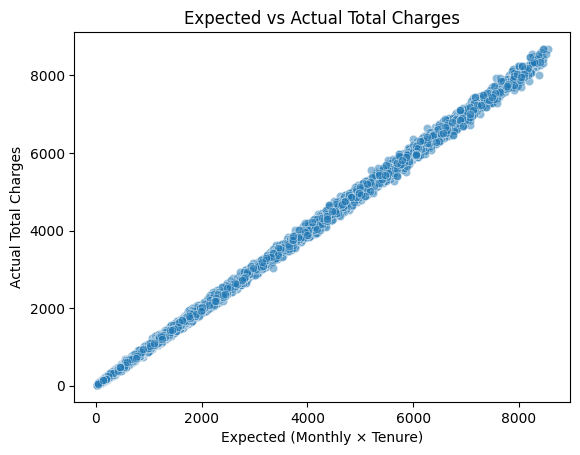

In [13]:
#check if the relationship is linear indicating whether i can assume such or no
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x='ExpectedTotal', y='TotalCharges', data=df_clean, alpha=0.5)
plt.title('Expected vs Actual Total Charges')
plt.xlabel('Expected (Monthly × Tenure)')
plt.ylabel('Actual Total Charges')
plt.show()

In [14]:
#filling out the empty string in TotalCharges

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("Missing TotalCharges before filling:", df['TotalCharges'].isna().sum())

#TotalCharges = MonthlyCharges * tenure
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = (
    df.loc[df['TotalCharges'].isna(), 'MonthlyCharges'] *
    df.loc[df['TotalCharges'].isna(), 'tenure']
)

#check
print("Missing TotalCharges after filling:", df['TotalCharges'].isna().sum())

Missing TotalCharges before filling: 11
Missing TotalCharges after filling: 0


In [15]:
fig = px.histogram(df, x="TotalCharges", nbins=30, title="Total Charges Distribution")
fig.show()

### Q4: Visualize churn distribution

In [16]:
# Create a bar plot for churn distribution
#check if all values look the same/missing values etc.
df['Churn'].value_counts(dropna=False)


Churn
No     5437
Yes    1958
Name: count, dtype: int64

In [17]:
#create the bar chart itself
counts = df['Churn'].value_counts().reset_index()
counts.columns = ['Churn', 'Count']
counts['Percent'] = (counts['Count'] / counts['Count'].sum() * 100).round(1)

fig = px.bar(
    counts,
    x='Churn',
    y='Count',
    text='Percent',
    title='Churn Distribution',
    labels={'Count': 'Number of Customers'}
)

fig.update_traces(texttemplate='%{text}%', textposition='outside')
fig.update_layout(yaxis_title='Number of Customers')
fig.show()

## Section 2 – Data Cleaning (20%)

### Q5: Convert `TotalCharges` to numeric and handle missing values

This is Already Performed in the previous step - so I will add the code again here as comment but will not run it

In [18]:
#df_clean = df.copy()
#df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

##Check missing values in TotalCharges
#print("Missing values in TotalCharges:", df_clean['TotalCharges'].isna().sum())

##drop rows with missing TotalCharges
#df_clean = df_clean.dropna(subset=['TotalCharges'])
#df_clean.reset_index(drop=True, inplace=True)
#print("Shape of cleaned dataset:", df_clean.shape)

##calculate expected total
#df_clean['ExpectedTotal'] = df_clean['MonthlyCharges'] * df_clean['tenure']

##calculate the difference
#df_clean['Difference'] = df_clean['TotalCharges'] - df_clean['ExpectedTotal']

##summary of the difference
#print("\nSummary of difference between Actual and Expected TotalCharges:")
#print(df_clean['Difference'].describe())

##check if the relationship is linear indicating whether i can assume such or no
#import seaborn as sns
#import matplotlib.pyplot as plt

#sns.scatterplot(x='ExpectedTotal', y='TotalCharges', data=df_clean, alpha=0.5)
#plt.title('Expected vs Actual Total Charges')
#plt.xlabel('Expected (Monthly × Tenure)')
#plt.ylabel('Actual Total Charges')
#plt.show()

**Reflection:** Why did you choose this method for handling missing values?

**My Opinion:** Instead of using means, modes, and other similar ways to fill the missing data, I decided to utilize the relationship between the already existing data (monthly charge and tenure). typically, total charges is the total charge is the monthly charge multiplied by the tenure (there might be some differences due to partial months for example; however, it still represents very accurate results with average mean of 0.17 and the plot of actual vs predicted showed strong linear relation. Accordingly, I decided to fill out the data for missing values by multiplying the monthly charge by the tenure.

**Note:** Missing values here can be imputed using the *Median* safely, since the data is skewed.

### Q6: Drop duplicate rows if any

In [30]:

#check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows before dropping:", duplicates)



Number of duplicate rows before dropping: 0


Same Number of duplicates in customer ID (it is highly likely that these are the same duplicates)

In [31]:
#remove duplicates based on customerID in a new df
df_noduplicates = df.drop_duplicates(subset='customerID')

#check for duplicates in CustomerID
print("Duplicate customerIDs:", df_noduplicates['customerID'].duplicated().sum())

#check for duplicates in general to confirm whether duplicates in columns are the same as ID or no
print("Full duplicate rows:", df_noduplicates.duplicated().sum())

Duplicate customerIDs: 0
Full duplicate rows: 0


It is confirmed, all duplicates of ID are duplicates across all columns

In [32]:
#implement the same in the original df
df = df.drop_duplicates(subset='customerID')
print("Duplicate customerIDs:", df['customerID'].duplicated().sum())
print("Full duplicate rows:", df.duplicated().sum())

Duplicate customerIDs: 0
Full duplicate rows: 0


## Section 3 – Feature Engineering (20%)

### Q7: Create `tenure_group` feature (0–12, 13–24, 25–48, 49+)

In [33]:
df.loc[:, 'tenure_group'] = pd.cut(
    df['tenure'],
    bins=[0, 12, 24, 48, float('inf')],
    labels=['0–12', '13–24', '25–48', '49+'],
    right=True
)
#show new data group
print(df['tenure_group'].value_counts())

tenure_group
49+      2239
0–12     2175
25–48    1594
13–24    1024
Name: count, dtype: int64


### Q8: Encode categorical variables

In [34]:
categorical_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
    'PaymentMethod'
]

for col in categorical_cols:
    print(f"\n{col}")
    print(df[col].value_counts(dropna=False))


gender
gender
Male      3555
Female    3488
Name: count, dtype: int64

Partner
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

PhoneService
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

OnlineBackup
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

DeviceProtection
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

TechSupport
TechSupport
No             

**The method I will use:** Since, CustomerID is a unique identifier I will not be encoding it as it will not be used in prediciton. Additionally, since there are a lot of categorical data I will not use one hot encoding as it will create multiple variables, so I will use label encoding

In [35]:
from sklearn.preprocessing import LabelEncoder
df_encoded = df.copy()

#excluding customerID (as mentioned above)
cols_to_encode = df_encoded.select_dtypes(include=['object']).columns.drop('customerID')

# Initialize label encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
for col in cols_to_encode:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Confirm encoding
print("Encoded columns:\n", cols_to_encode.tolist())
print("\nSample data:")
print(df_encoded.head(30))

Encoded columns:
 ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Sample data:
    customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0   7590-VHVEG       0              0        1           0       1   
1   5575-GNVDE       1              0        0           0      34   
2   3668-QPYBK       1              0        0           0       2   
3   7795-CFOCW       1              0        0           0      45   
4   9237-HQITU       0              0        0           0       2   
5   9305-CDSKC       0              0        0           0       8   
6   1452-KIOVK       1              0        0           1      22   
7   6713-OKOMC       0              0        0           0      10   
8   7892-POOKP       0              0        1           0      28   
9   6388-TABGU     

In [36]:
##to add the tenure_group
df_encoded['tenure_group'] = LabelEncoder().fit_transform(df_encoded['tenure_group'])
df_encoded.head(30)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,1,2,29.85,29.85,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,0,0,0,1,0,3,56.95,1889.50,0,2
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,1,3,53.85,108.15,1,0
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,0,0,1,0,0,42.30,1840.75,0,2
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,1,2,70.70,151.65,1,0
5,9305-CDSKC,0,0,0,0,8,1,2,1,0,...,0,2,2,0,1,2,99.65,820.50,1,0
6,1452-KIOVK,1,0,0,1,22,1,2,1,0,...,0,2,0,0,1,1,89.10,1949.40,0,1
7,6713-OKOMC,0,0,0,0,10,0,1,0,2,...,0,0,0,0,0,3,29.75,301.90,0,0
8,7892-POOKP,0,0,1,0,28,1,2,1,0,...,2,2,2,0,1,2,104.80,3046.05,1,2
9,6388-TABGU,1,0,0,1,62,1,0,0,2,...,0,0,0,1,0,0,56.15,3487.95,0,3


## Section 4 – Simple Modelling (15%)

### Q9: Split dataset into train/test (70/30)

In [37]:
#defining the features and the label
X = df_encoded.drop(['Churn', 'customerID'], axis=1)  # features
y = df_encoded['Churn']  # target variable

#splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### Q10: Fit Logistic Regression and compute accuracy

In [38]:
model = LogisticRegression(max_iter=800)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))


Accuracy: 0.807382867960246


**Note:** Typically, we might not necessarily use all variables depending on their importance but for this assignment, I will leave all variables except for CustomerID (as it is a unique identifier)

### Q11: Research First, Then Compute

Before coding, do the research in Section 5.

Then, compute precision and recall for the churn class using your model.


In [39]:
##calculating precision and recall for the churn class
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision for Churn class: {precision:.3f}")
print(f"Recall for Churn class: {recall:.3f}")

Precision for Churn class: 0.673
Recall for Churn class: 0.566


In [40]:
##classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1539
           1       0.67      0.57      0.61       574

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113



## Section 5 – Research & Reflection (20%)

### Q12: Why is accuracy not enough in churn prediction?
**Most of the people do not churn, so a model that always predicts no churn will be highly accurate, but will fail to capture people who churn (which is who we are more concerned with)**

### Q13: Research Task
Search what **precision**, **recall**, and a **classification report** mean in classification problems.


**Precision focuses on the quality of positive predictions which basically computes how many of the predicted positives are real positives**

**Recall focuses on the ability to capture true positives through computing how many of the real positives did the model predict**

**Classification report is a summary table that provides precision, recall, and f1-score for each class which allows us to see if the model performs better on one of the outputs than the other.**

Why might recall be more important than precision in churn prediction?
**We are more concerned with capturing as many churners as possible to improve the service or analyze reasons for churning. A low recall means the model fails to identify many of the actual churners, giving a false impression that more customers are loyal than they really are. On the other hand, a low precision means the model predicts more churners than actually exist, which may mislead decision-makers into thinking churn is higher; however, this is less harmful than missing real churners.**